In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC,SVR
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.decomposition import PCA 
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc
import os,sys
from pathlib import Path
import pandas as pd
import csv

def importAndPreprocess(dirPath,activityFileName):
    import os
    import sys

    
    with np.load(os.path.join(dirPath,activityFileName),allow_pickle=True) as f:
        x = f['x']
        trial_params = f['trial_params']
        model_output = f['model_output']
        model_state = f['model_state']
        mask = f.get('mask', None)
    
    if mask is None:
        temp = np.mean(model_output[:,300:,:],1)
    else: 
        temp = np.mean(mask * model_output,1)
    choiceLR = temp[:,1]>temp[:,0]
    choiceLR = choiceLR*2-1 # pos right high, neg left high
    
    choiceFrame = [trial_params[i]['choiceFrame'] for i in range(len(trial_params))]
    
    
    locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
    loc12 = locAB
    seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
    
    choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos B neg A
    choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos 2 neg 1
    choiceAB = np.array(['B' if choiceAB[i]>0 else 'A' for i in range(len(trial_params))])
    choice12 = np.array(['2' if choice12[i]>0 else '1' for i in range(len(trial_params))])
    
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqAB = np.array([trial_params[i]['seqAB']for i in range(len(trial_params))])

    return x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB

In [2]:
from github_packages.neural_dynamics_gyration.utils.utils import compute_lambdas,compute_gyration
dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-14-12_10_notFail'
# dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-14-12_0_notFail'
x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTestGrid.npz')
data_to_estimate_rotation = model_state[:,50:250,:]
decay,rotation = compute_gyration(data_to_estimate_rotation)
print(decay,rotation)

0.14779006 0.5448861


In [13]:
dirName = 'alternateTaskDefault'
# dirName = 'juiceTaskDefault'
from github_packages.neural_dynamics_gyration.utils.utils import compute_lambdas,compute_gyration

f = open(os.path.join('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/',
                        'activityAnalysis.rotation.'+dirName+'.csv'), 
                        'w')
writer = csv.writer(f)
writer.writerow([
    'decay_axis',
    'rotation_axis',
    'dirPath',
])
root = "/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/"+dirName
for name in os.listdir(root):
    dirPath = os.path.join(root,name)
    if os.path.isdir(dirPath):
        # print(dirPath)
        x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTestGrid.npz')
        data_to_estimate_rotation = model_state[:,50:250,:]
        decay,rotation = compute_gyration(data_to_estimate_rotation)
        writer.writerow([
            decay,
            rotation,
            dirPath
        ])
f.close()


In [2]:
csv_order_rotation = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.rotation.orderTaskDefault.csv',
    header=0)
csv_juice_rotation = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.rotation.juiceTaskDefault.csv',
    header=0)    
csv_order = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.orderTaskDefault.csv',
    header=1)
csv_juice = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.juiceTaskDefault.csv',
    header=1)    
csv_both_rotation = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.rotation.alternateTaskDefault.csv',
    header=0)

/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='decay_axis', ylabel='rotation_axis'>

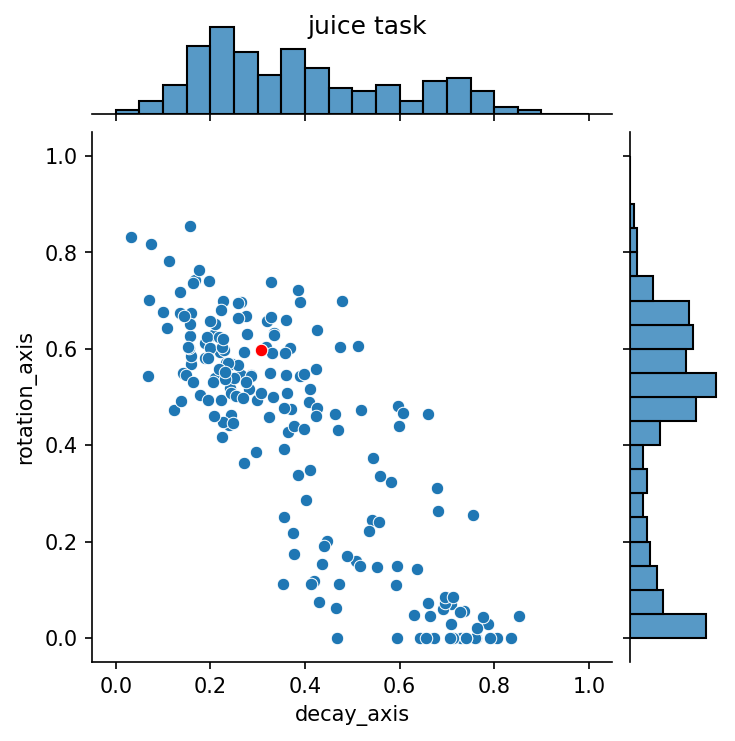

In [13]:
import seaborn as sns
exampleJuice = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_'
exampleOrder = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_'

xExample = csv_juice_rotation.loc[csv_juice_rotation['dirPath']==exampleJuice,:]

bins = np.linspace(0,1,21)
p = sns.jointplot(csv_juice_rotation,x='decay_axis',y='rotation_axis',marginal_kws=dict(bins=bins),height=5)
p.fig.suptitle('juice task')
p.fig.set_dpi(150)
sns.scatterplot(xExample,x='decay_axis',y='rotation_axis',color='red')


/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='decay_axis', ylabel='rotation_axis'>

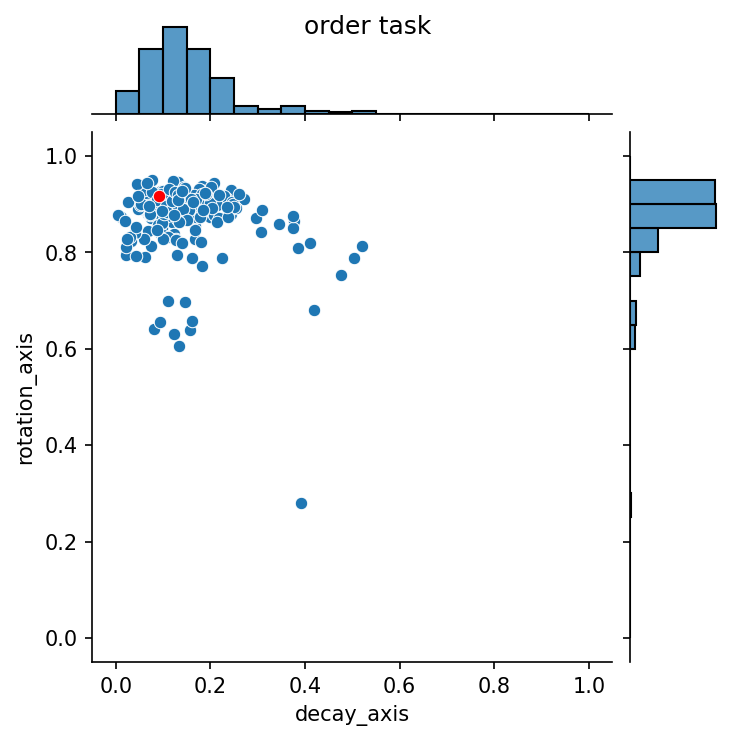

In [12]:
import seaborn as sns

xExample = csv_order_rotation.loc[csv_order_rotation['dirPath']==exampleOrder,:]


bins = np.linspace(0,1,21)
p = sns.jointplot(csv_order_rotation,x='decay_axis',y='rotation_axis',marginal_kws=dict(bins=bins),height=5)
p.fig.suptitle('order task')
p.fig.set_dpi(150)
sns.scatterplot(xExample,x='decay_axis',y='rotation_axis',color='red')


/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


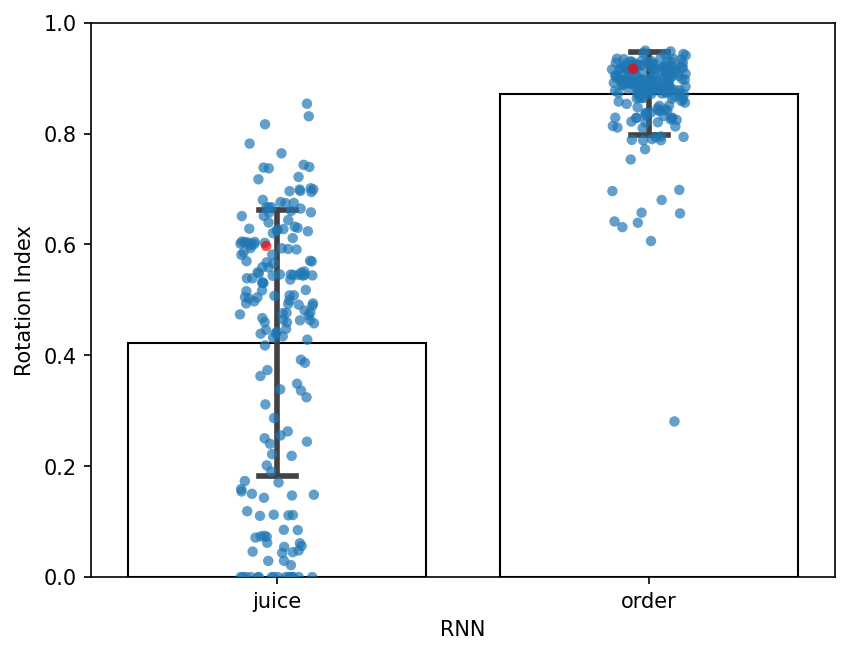

In [38]:
def barStat(csv_juice,csv_order,y_var,ylabel):
    fig,ax = plt.subplots(dpi=150)
    import seaborn as sns
    import pandas as pd
    csv_order['RNN'] = 'order'
    csv_juice['RNN'] = 'juice'
    exampleJuice = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_'
    exampleOrder = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_'
    csv_order['example'] = False
    csv_juice['example'] = False
    csv_order.loc[csv_order['dirPath']==exampleOrder,'example'] = True
    csv_juice.loc[csv_juice['dirPath']==exampleJuice,'example'] = True
    csv = pd.concat([csv_juice,csv_order])
    csv=csv.sort_values(by=['example'],ascending=True)
    sns.barplot(data=csv,x='RNN',y=y_var, capsize=.1, errorbar="sd",ax=ax,fill=False,order=['juice','order'])
    sns.stripplot(data=csv,x='RNN',y=y_var, alpha=.7, hue='example', legend=False,ax=ax,palette={False:'tab:blue',True:'red'},order=['juice','order'])
    ax.set_ylabel(ylabel)
    ax.set_ylim((0,1))

barStat(csv_order=csv_order_rotation,csv_juice=csv_juice_rotation,y_var='rotation_axis',ylabel='Rotation Index')

/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


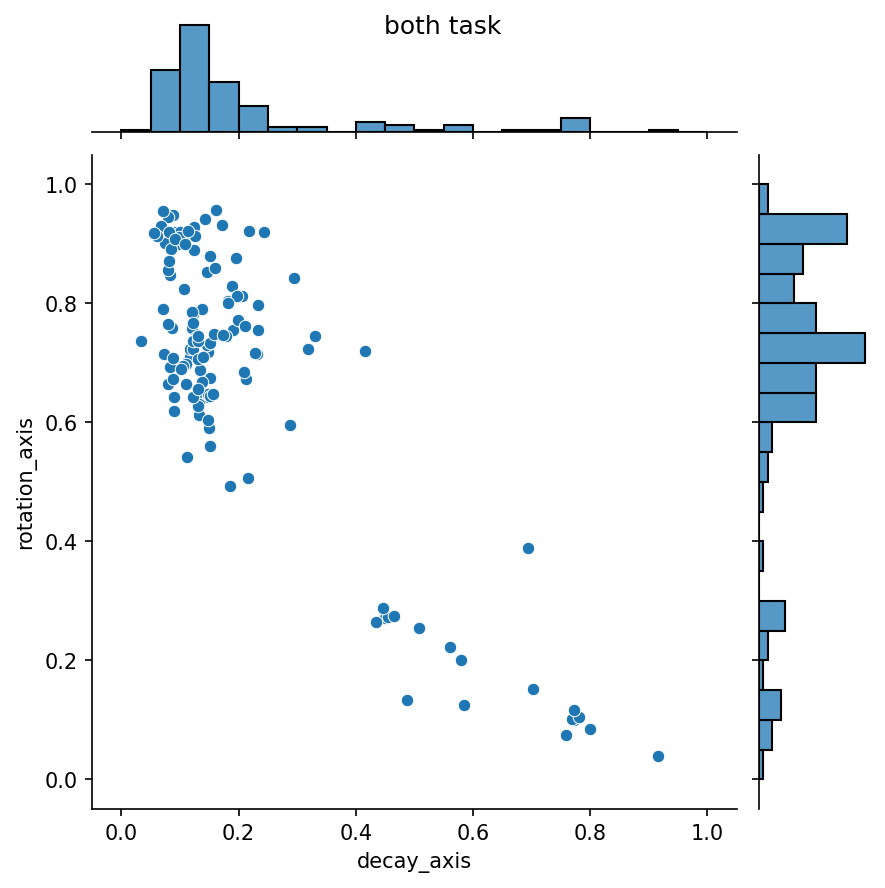

In [8]:
import seaborn as sns
bins = np.linspace(0,1,21)
p = sns.jointplot(csv_both_rotation,x='decay_axis',y='rotation_axis',marginal_kws=dict(bins=bins))
p.fig.suptitle('both task')
p.fig.set_dpi(150)


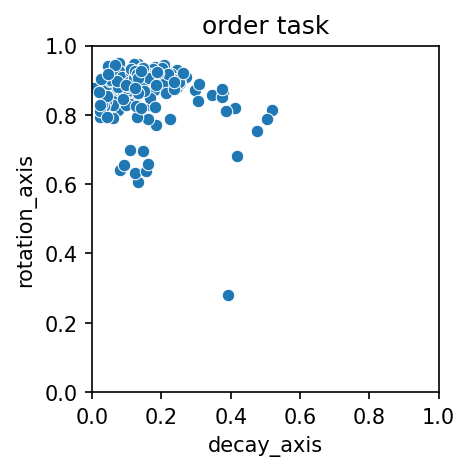

In [5]:
import seaborn as sns
fig = plt.figure(dpi=150,figsize=(4,3))
sns.scatterplot(csv_order_rotation,x='decay_axis',y='rotation_axis')
plt.title('order task')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect(1)

Text(0, 0.5, 'rotation index - gyration')

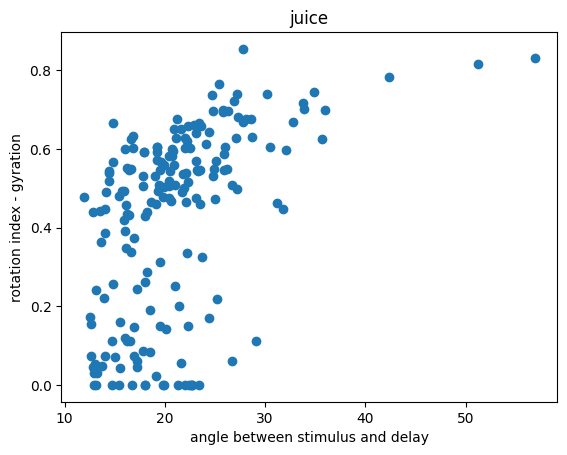

In [5]:
plt.scatter((csv_juice['angle_tEarly_tDelay_A']+csv_juice['angle_tEarly_tDelay_B'])/2*180/np.pi,csv_juice_rotation['rotation_axis'])
plt.title('juice')
plt.xlabel('angle between stimulus and delay')
plt.ylabel('rotation index - gyration')

Text(0, 0.5, 'rotation index - gyration')

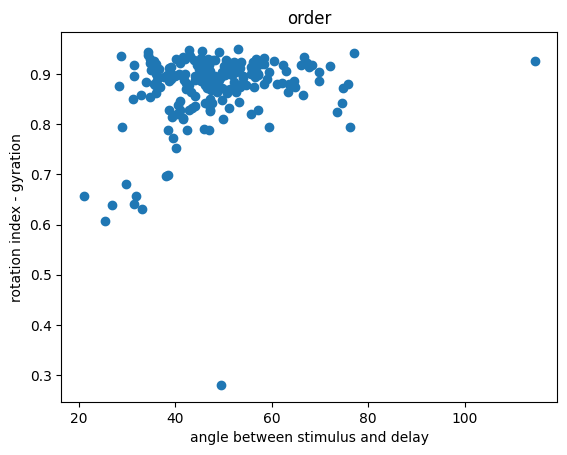

In [13]:
plt.scatter((csv_order['angle_tEarly_tDelay_A']+csv_order['angle_tEarly_tDelay_B'])/2*180/np.pi,csv_order_rotation['rotation_axis'])
plt.title('order')
plt.xlabel('angle between stimulus and delay')
plt.ylabel('rotation index - gyration')

In [16]:
dirPath = csv_order_rotation[csv_order_rotation['rotation_axis']<0.4]['dirPath'].item()

,decay_axis,rotation_axis,dirPath
64,0.392339,0.280746,/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/o...


In [19]:
csv_order.loc[64,'PR 50-250']

1.7349536968540966